# Sentiment Analysis using Recurrent Neural Network (LSTM & BiLSTM)

In [37]:
# Importing necessary modules and packages

import re
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# Plot libraries
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt


In [38]:
# Reading the dataset

DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('./training.1600000.processed.noemoticon.csv',
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)
dataset.head(10)

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


In [39]:
#taking subset of 200000 from whole dataset with 1.6 million datapoints

dataset = dataset.sort_values(by=['sentiment'])
dataset.reset_index(drop=True, inplace=True)
dataset_neg = dataset.head(100000)
dataset_pos = dataset.tail(100000)
frames = [dataset_neg, dataset_pos]
dataset = pd.concat(frames)
dataset.reset_index(drop=True, inplace=True)

In [40]:
dataset.head()

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,2197102502,Tue Jun 16 13:20:43 PDT 2009,NO_QUERY,Papps93,@Barber_21 i've never ever played an instrume...
2,0,2197102654,Tue Jun 16 13:20:44 PDT 2009,NO_QUERY,LuLu88A,@Fumm Ooo dont say that u
3,0,2197102915,Tue Jun 16 13:20:45 PDT 2009,NO_QUERY,guytp,Nose filled with ick is no fun
4,0,2197102918,Tue Jun 16 13:20:45 PDT 2009,NO_QUERY,XxAmziexX,I just wanna sleep so badly


In [41]:
dataset.tail()

,sentiment,ids,date,flag,user,text
199995,4,1965353425,Fri May 29 15:46:16 PDT 2009,NO_QUERY,lynnojebe,@stephaniepratt the short orange one!!! Soo pr...
199996,4,1965353441,Fri May 29 15:46:16 PDT 2009,NO_QUERY,johnnnaa,@jaykpurdy hah varsity fanclub is on a board
199997,4,1965353448,Fri May 29 15:46:18 PDT 2009,NO_QUERY,karinlinardy,@AndyTheSamurai been there before it's a cool...
199998,4,1965337069,Fri May 29 15:44:32 PDT 2009,NO_QUERY,caitlinlavergne,Going to pick up Lakin. Leaving Brightside ton...
199999,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


In [42]:
dataset = dataset[['sentiment','text']] #taking only sentiment & text columns
dataset['sentiment'] = dataset['sentiment'].replace(4,1) # replacing positive sentiment code from '4' to '1' 

In [43]:
#https://www.kaggle.com/code/alexcherniuk/imdb-review-word2vec-bilstm-99-acc
#plotting histogram of tweets
dataset['tweet_length'] = np.array(list(map(len, dataset.text)))
median = dataset['tweet_length'].median()
mean = dataset['tweet_length'].mean()
mode = dataset['tweet_length'].mode()[0]

Text(0, 0.5, 'Number of tweets')

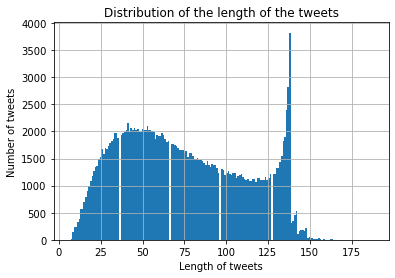

In [44]:
dataset['tweet_length'].hist(bins=dataset['tweet_length'].max(), range=(min(dataset.tweet_length), max(dataset.tweet_length)))
plt.title("Distribution of the length of the tweets")
plt.xlabel("Length of tweets")
plt.ylabel("Number of tweets")

In [45]:
print("Minimum length of the tweet is ", min(dataset.tweet_length))
print("Maximum length of the tweet is ", max(dataset.tweet_length))

Minimum length of the tweet is  6
Maximum length of the tweet is  188


/Users/vigingeorge/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


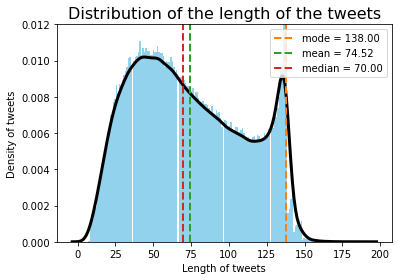

In [46]:
fig, ax = plt.subplots()
sns.distplot(dataset['tweet_length'], bins=dataset['tweet_length'].max(),
            hist_kws={"alpha": 0.9, "color": "skyblue"}, ax=ax,
            kde_kws={"color": "black", 'linewidth': 2})
# ax.set_xlim(left=0, right=np.percentile(dataset['tweet_length'], 95))
# ax.set_xlabel('Number of words in the tweets')
ymax = 0.012
plt.ylim(0, ymax)
ax.plot([mode, mode], [0, ymax], '--', label=f'mode = {mode:.2f}', linewidth=2)
ax.plot([mean, mean], [0, ymax], '--', label=f'mean = {mean:.2f}', linewidth=2)
ax.plot([median, median], [0, ymax], '--',label=f'median = {median:.2f}', linewidth=2)
ax.set_title('Distribution of the length of the tweets', fontsize=16)
plt.xlabel("Length of tweets")
plt.ylabel("Density of tweets")
plt.legend()
plt.show()

In [47]:
dataset.pop('tweet_length')

0         115
1         107
2          26
3          31
4          28
         ... 
199995     53
199996     45
199997     84
199998     56
199999     62
Name: tweet_length, Length: 200000, dtype: int64

Text(0, 0.5, 'Number of tweets')

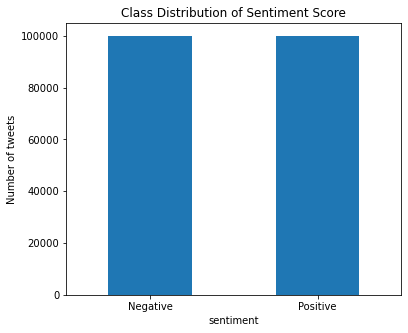

In [48]:
# Barplot of sentiments
gpn = dataset.groupby('sentiment').count().plot(kind='bar', title='Class Distribution of Sentiment Score', figsize= (6,5),legend=False,)
gpn = gpn.set_xticklabels(['Negative','Positive'], rotation=0)
plt.ylabel("Number of tweets")

In [49]:
contractions = pd.read_csv('contractions.csv', index_col='Contraction')
contractions.index = contractions.index.str.lower()
contractions.Meaning = contractions.Meaning.str.lower()
contractions_dict = contractions.to_dict()['Meaning']

In [51]:
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Defining regex for emojis
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"

In [52]:
def preprocess_apply(tweet):

    tweet = tweet.lower()

    # Replace all URls with '<url>'
    tweet = re.sub(urlPattern,'<url>',tweet)
    # Replace @USERNAME to '<user>'.
    tweet = re.sub(userPattern,'<user>', tweet)
    
    # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    # Replace all emojis.
    tweet = re.sub(r'<3', '<heart>', tweet)
    tweet = re.sub(smileemoji, '<smile>', tweet)
    tweet = re.sub(sademoji, '<sadface>', tweet)
    tweet = re.sub(neutralemoji, '<neutralface>', tweet)
    tweet = re.sub(lolemoji, '<lolface>', tweet)

    for contraction, replacement in contractions_dict.items():
        tweet = tweet.replace(contraction, replacement)

    # Remove non-alphanumeric and symbols
    tweet = re.sub(alphaPattern, ' ', tweet)

    # Adding space on either side of '/' to seperate words (After replacing URLS).
    tweet = re.sub(r'/', ' / ', tweet)
    return tweet

In [53]:
dataset.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,@Barber_21 i've never ever played an instrume...
2,0,@Fumm Ooo dont say that u
3,0,Nose filled with ick is no fun
4,0,I just wanna sleep so badly


In [54]:
%%time
dataset['processed_text'] = dataset.text.apply(preprocess_apply)

CPU times: user 9.8 s, sys: 118 ms, total: 9.91 s
Wall time: 10.1 s


In [55]:
# Displaying processed tweets
count=0
for row in dataset.itertuples():
    print("Text:", row[2])
    print("Processed:", row[3])
    count+=1
    if count>10:
        break

Text: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
Processed: <user> <url>   aww  thatis a bummer   you shoulda got david carr of third day to do it  <smile>
Text: @Barber_21  i've never ever played an instrument  and yeah if ure ever in this part of the world... say hi!
Processed: <user>  i have never ever played an instrument  and yeah if ure ever in this part of the world   say hi 
Text: @Fumm Ooo  dont say that u
Processed: <user> oo  dont say that u
Text: Nose filled with ick is no fun 
Processed: nose filled with ick is no fun 
Text: I just wanna sleep so badly 
Processed: i just want to sleep so badly 
Text: Okay I lost everyone on my buddylist.. Does anyone know how to restore it!? 
Processed: okay i lost everyone on my buddylist   does anyone know how to restore it   
Text: i am extreeeemely lost without him 
Processed: i am extreemely lost without him 
Text: I have a headache 
Processed: i have a headache 

#### Word Cloud

In [56]:
# Creating word cloud

processedtext = list(dataset['processed_text'])
data_pos = processedtext[100000:]
data_neg = processedtext[:100000]

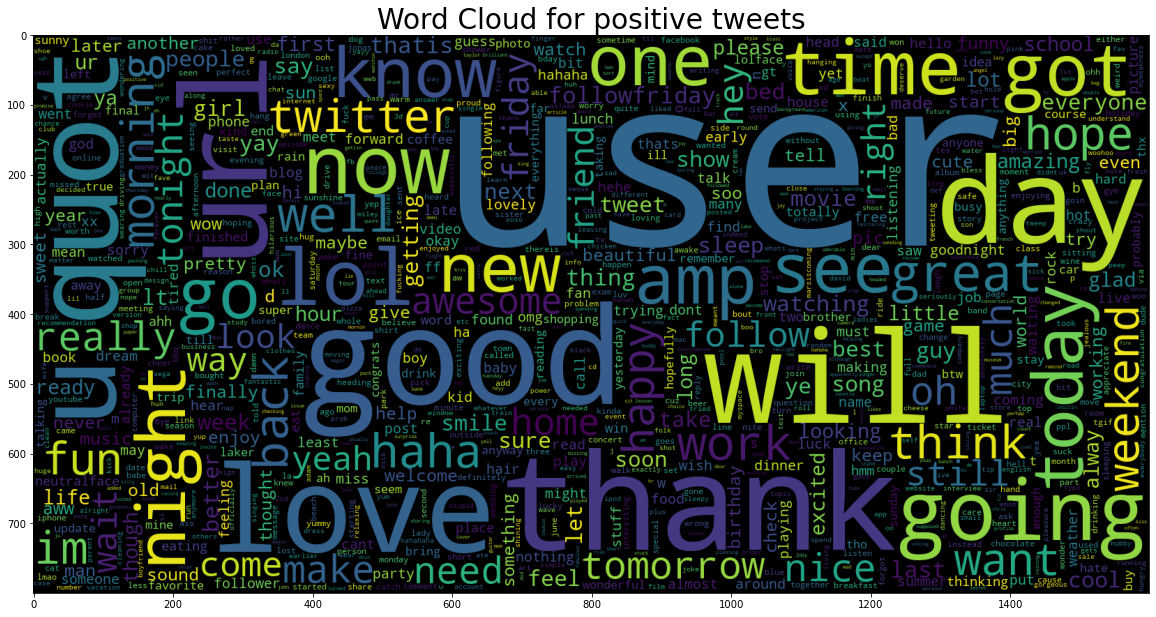

In [57]:
# Positive Word Cloud
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.title("Word Cloud for positive tweets", fontsize=28)
plt.imshow(wc)

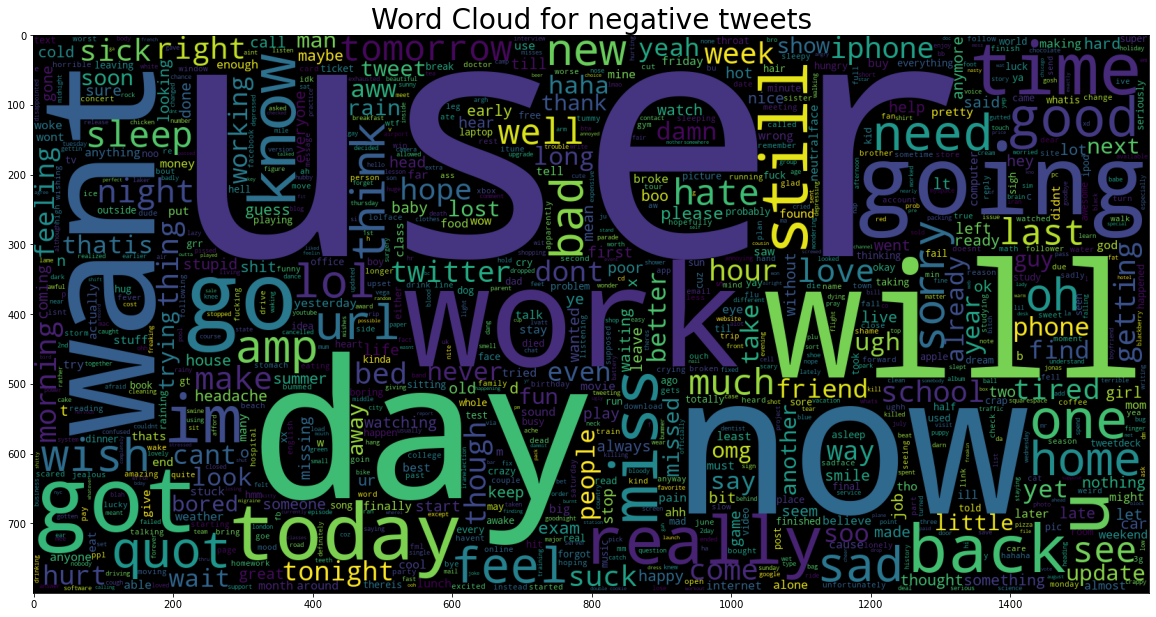

In [23]:
# Negative Word Cloud
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.figure(figsize = (20,20))
plt.title("Word Cloud for negative tweets", fontsize=28)
plt.imshow(wc)

In [58]:
# Splitting train & test data

X_data, y_data = np.array(dataset['processed_text']), np.array(dataset['sentiment'])

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size = 0.1, random_state = 0)
print('Data Split done.')

Data Split done.


In [59]:
# Word Embedding
Embedding_dimensions = 100

# Creating Word2Vec training dataset.
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

# %%time

# Defining the model and training it.
word2vec_model = Word2Vec(Word2vec_train_data,
                 vector_size=Embedding_dimensions,
                 workers=8,
                 min_count=5)

print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))

Vocabulary Length: 15081


In [60]:
# Defining the model input length.
input_length = 150

# Tokenization
vocab_length = 20000

tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X_data)
tokenizer.num_words = vocab_length
print("Tokenizer vocab length:", vocab_length)

Tokenizer vocab length: 20000


In [61]:
# Padding

X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=input_length)

print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)

X_train.shape: (180000, 150)
X_test.shape : (20000, 150)


In [62]:
# Creating embedded matrix

embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (20000, 100)


In [64]:
# bi-LSTM#
def getModel_biLSTM():
    
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights = [embedding_matrix],
                                input_length=input_length,
                                trainable=False)
    model = Sequential([embedding_layer,
                        Bidirectional(LSTM(100, dropout=0.3,  return_sequences=True)),
                        Conv1D(100, 5, activation='relu'),
                        GlobalMaxPool1D(),
                        Dense(16, activation='relu'),
                        Dense(8, activation='relu'),
                        Dense(1, activation='sigmoid')], name="Sentiment_Model_biLSTM")
    return model

In [65]:
# biLSTM Model
training_model_biLSTM = getModel_biLSTM()
training_model_biLSTM.summary()

Model: "Sentiment_Model_biLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 150, 100)          2000000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 150, 200)         160800    
 nal)                                                            
                                                                 
 conv1d_1 (Conv1D)           (None, 146, 100)          100100    
                                                                 
 global_max_pooling1d_1 (Glo  (None, 100)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_3 (Dense)             (None, 16)                1616      
                                                                 
 dense_4 (Dense)             (None, 8)      

In [66]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [67]:
training_model_biLSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [68]:
history_biLSTM = training_model_biLSTM.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=12,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/12
159/159 [==============================] - 830s 5s/step - loss: 0.5008 - accuracy: 0.7540 - val_loss: 0.4506 - val_accuracy: 0.7848 - lr: 0.0010
Epoch 2/12
159/159 [==============================] - 866s 5s/step - loss: 0.4517 - accuracy: 0.7865 - val_loss: 0.4339 - val_accuracy: 0.7946 - lr: 0.0010
Epoch 3/12
159/159 [==============================] - 904s 6s/step - loss: 0.4339 - accuracy: 0.7969 - val_loss: 0.4212 - val_accuracy: 0.8005 - lr: 0.0010
Epoch 4/12
159/159 [==============================] - 891s 6s/step - loss: 0.4200 - accuracy: 0.8048 - val_loss: 0.4159 - val_accuracy: 0.8027 - lr: 0.0010
Epoch 5/12
159/159 [==============================] - 876s 6s/step - loss: 0.4104 - accuracy: 0.8101 - val_loss: 0.4153 - val_accuracy: 0.8067 - lr: 0.0010
Epoch 6/12
159/159 [==============================] - 882s 6s/step - loss: 0.4014 - accuracy: 0.8155 - val_loss: 0.4108 - val_accuracy: 0.8056 - lr: 0.0010
Epoch 7/12
159/159 [==============================] - 788s 5s/st

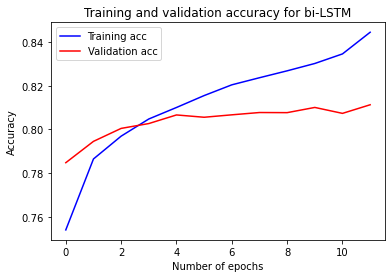

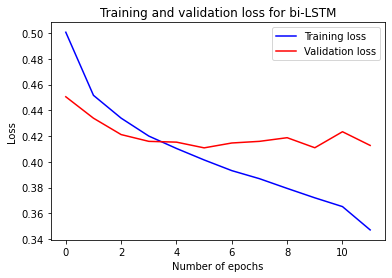

In [70]:
acc,  val_acc  = history_biLSTM.history['accuracy'], history_biLSTM.history['val_accuracy']
loss, val_loss = history_biLSTM.history['loss'], history_biLSTM.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy for bi-LSTM')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss for bi-LSTM')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [71]:
def ConfusionMatrix(y_pred, y_test):
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

625/625 [==============================] - 46s 74ms/step

 Evaluation metrics for bi-LSTM Model


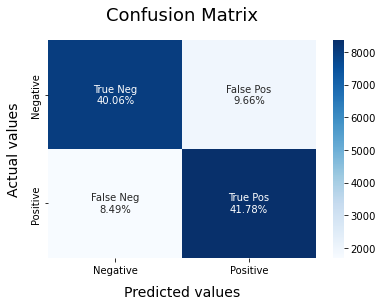

In [73]:
# Predicting on the Test dataset.
y_pred_biLSTM = training_model_biLSTM.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
y_pred_biLSTM = np.where(y_pred_biLSTM >= 0.5, 1, 0)

# Printing out the Evaluation metrics.
print("\n Evaluation metrics for bi-LSTM Model")
ConfusionMatrix(y_pred_biLSTM, y_test)

In [74]:
# Print the classification report for biLSTM Model
print("\n Classification report for bi-LSTM Model")
print(classification_report(y_test, y_pred_biLSTM))


 Classification report for bi-LSTM Model
              precision    recall  f1-score   support

           0       0.83      0.81      0.82      9946
           1       0.81      0.83      0.82     10054

    accuracy                           0.82     20000
   macro avg       0.82      0.82      0.82     20000
weighted avg       0.82      0.82      0.82     20000



In [75]:
#LSTM#
def getModel_LSTM():
    
    embedding_layer = Embedding(input_dim=vocab_length,
                                output_dim=Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)
    model = Sequential([embedding_layer,
                        LSTM(100, dropout=0.3, recurrent_dropout=0.3),
                        Dense(16, activation='relu'),
                        Dense(8, activation='relu'),
                        Dense(1, activation='sigmoid')], name="Sentiment_Model_LSTM")
    return model

In [76]:
# LSTM Model

training_model_LSTM = getModel_LSTM()
training_model_LSTM.summary()

Model: "Sentiment_Model_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 150, 100)          2000000   
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dense_6 (Dense)             (None, 16)                1616      
                                                                 
 dense_7 (Dense)             (None, 8)                 136       
                                                                 
 dense_8 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,082,161
Trainable params: 82,161
Non-trainable params: 2,000,000
_________________________________________________________________


In [78]:
training_model_LSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history_LSTM = training_model_LSTM.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=12,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/12
159/159 [==============================] - 421s 3s/step - loss: 0.5212 - accuracy: 0.7388 - val_loss: 0.4629 - val_accuracy: 0.7804 - lr: 0.0010
Epoch 2/12
159/159 [==============================] - 448s 3s/step - loss: 0.4727 - accuracy: 0.7717 - val_loss: 0.4553 - val_accuracy: 0.7827 - lr: 0.0010
Epoch 3/12
159/159 [==============================] - 485s 3s/step - loss: 0.4569 - accuracy: 0.7817 - val_loss: 0.4396 - val_accuracy: 0.7902 - lr: 0.0010
Epoch 4/12
 88/159 [===============>..............] - ETA: 3:43 - loss: 0.4471 - accuracy: 0.7892

In [ ]:
# Plotting accuracy & loss for LSTM Model
acc,  val_acc  = history_LSTM.history['accuracy'], history_LSTM.history['val_accuracy']
loss, val_loss = history_LSTM.history['loss'], history_LSTM.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy for LSTM Model')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss for LSTM Model')
plt.legend()

plt.show()

In [ ]:
# Predicting on the Test dataset.
y_pred_LSTM = training_model_LSTM.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
y_pred_LSTM = np.where(y_pred_LSTM >= 0.5, 1, 0)

# Printing out the Evaluation metrics.
print("\n Evaluation metrics for LSTM Model")
ConfusionMatrix(y_pred_LSTM, y_test)

In [ ]:
# Print the classification report for LSTM Model
print("\n Classification report for LSTM Model")
print(classification_report(y_test, y_pred_LSTM))

In [ ]:
#SimpleRNN#
#https://www.kaggle.com/code/tanulsingh077/deep-learning-for-nlp-zero-to-transformers-bert#
def getModel_SimpleRNN():
    embedding_layer = Embedding(input_dim=vocab_length,
                                output_dim=Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        SimpleRNN(100),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid'),
    ],
        name="Sentiment_Model_SimpleRNN")
    return model

In [ ]:
training_model_SimpleRNN = getModel_SimpleRNN()
training_model_SimpleRNN.summary()
training_model_SimpleRNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history_SimpleRNN = training_model_SimpleRNN.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=12,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)

In [ ]:
# Plotting accuracy & loss for SimpleRNN Model
acc,  val_acc  = history_LSTM.history['accuracy'], history_LSTM.history['val_accuracy']
loss, val_loss = history_LSTM.history['loss'], history_LSTM.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy for RNN Model')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss for RNN Model')
plt.legend()

plt.show()

In [ ]:
# Predicting on the Test dataset.
y_pred_RNN = training_model_SimpleRNN.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
y_pred_RNN = np.where(y_pred_RNN >= 0.5, 1, 0)

# Printing out the Evaluation metrics.
print("\n Evaluation metrics for RNN Model")
ConfusionMatrix(y_pred_RNN, y_test)

In [ ]:
# Print the classification report for RNN Model
print("\n Classification report for RNN Model")
print(classification_report(y_test, y_pred_RNN))